# Anomaly Detection

The goal of this notebook is to peform Anomaly Detection on Poland Cars Dataset & draw meaningful insights

**In order to smooth run of this notebook, make sure you have csv for the car dataset stored in the same folder as this notebook in your repo.**

## Library & Data Import

In [1]:
#### supress warnings ####
import warnings
warnings.filterwarnings('ignore')

import pdb
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter,ScalarFormatter
from sklearn.metrics import precision_score, recall_score, f1_score

#### Remove Scientic Notation While Displaying Pandas Data
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
car_sales_df = pd.read_csv('Car_sale_ads.csv') #### Read csv as dataframe & drop index column
car_sales_df.head(3) 

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.000,...,Manual,small_cars,3.000,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.000,...,Manual,coupe,2.000,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.000,...,Automatic,small_cars,3.000,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."


## Functions

In [3]:
def percent_value_counts(df,column):
    """This function takes input dataframe & generates value counts for each group in given column as percentage of total observations

    Args:
        df (dataframe): input dataframe
        column (string): column name from input dataframe 

    Returns:
        dataframe: pandas series indicating percentage of observations for each group within specified column
    """    
    
    percentage_counts = (df[column].value_counts(normalize=True) * 100).apply(lambda x: f'{x:.2f}%')
    
    return percentage_counts

In [4]:
def plot_hist(df,col,bins,x_label,formatter=True,kde=False,skewness=False):
    """This function plots histogram using seaborn for given dataframe column & granularity

    Args:
        df (dataframe): input dataframe
        col (string): column name for which histogram is plotted
        bins (integer): histogram binning granularity 
        x_label (string): X axis label 
        kde (boolean): Flag indicating addition of kde parameter
        formatter (boolean): Flag to tweak scientific notation
        skewness (boolean): Flag indication addition of skew calculation
        
    Returns:
        skew: skew value of column distribution
    """    
    plt.figure(figsize=(12, 8))  # Width: 12, Height: 8
    sns.histplot(df[col],kde=kde,bins=bins, color='blue')
    plt.title('Distribution of '+col)
    plt.xlabel(x_label)
    plt.ylabel('Frequency')

    if(formatter):
        # Remove scientific notation
        ax = plt.gca()  # Get the current axes
        ax.ticklabel_format(style='plain', axis='both')  # Set plain formatting for both axes

    plt.xticks(rotation=90)
    plt.show()
    
    if(skewness):
        skew = df[col].skew()
    else:
        skew = None
    
    return skew

In [5]:
def format_fn(value,tick_number):
    """This function is used for removing scientific notation from given value

    Args:
        value (float): Floating Number
        tick_number (integer) : Tick Number on Given Axis
    Returns:
        float_: regulat floating number without scientific notation
    """ 
    return '{:,.0f}'.format(value)  # Format the number as a regular float without scientific notation

In [6]:
def plot_boxplot(df,col):
    """This function plots boxplot for given datafram column

    Args:
        df (dataframe): input dataframe
        col (str): column name
    """    

    # Create the box plot
    plt.figure(figsize=(12, 6))  # Adjust the figure size (width, height)
    sns.boxplot(x=df[col])

    ax = plt.gca()  # Get the current axes
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn)) # Remove scientific notation from the axes using FuncFormatter
    ax.yaxis.set_major_formatter(FuncFormatter(format_fn)) # Remove scientific notation from the axes using FuncFormatter

    # Title and labels
    plt.title('Boxplot of '+col)
    plt.xlabel(col)

    # Show the plot
    plt.show()
    return

In [7]:
def perform_IQR(df,col,multiplier=1.5):
    """This function performs Inter-Quartile Range Operation On Given Dataframe & Returns Dataframe of Outlier Observations

    Args:
        df (dataframe): input dataframe
        col (string): column name

    Returns:
        dataframe: dataframe of outlier observations
    """    

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
    return outliers,upper_bound,lower_bound

In [8]:
def plot_line(df,x,y):
    """This function will plot line graph 

    Args:
        df (dataframe): Input dataframe 
        x (string): x-axis value
        y (string): y-axis value
    """    
    
    plt.figure(figsize=(10, 6))
    # sns.lineplot(data=df, x=x, y=y, marker='o')
    sns.lineplot(data=df, x=df[x].to_numpy(), y=df[y].to_numpy(), marker='o')

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.yaxis.get_major_formatter().set_scientific(False)

    # Customizing the plot
    plt.title(y+" vs "+x, fontsize=16)
    plt.xlabel(x,fontsize=12)
    plt.ylabel(y,fontsize=12)
    plt.grid(True)
    plt.show()
    
    return

In [9]:
def plot_scatter(df,x,y,metric):
    """This function will plot scatterplot

    Args:
        df (dataframe): input dataframe 
        x (string): x-axis name
        y (string): y-axis name
        metric (string): metric name
    """    
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x], df[y], c=df[metric], cmap='coolwarm', marker='o', edgecolor='k',alpha=0.5)
    plt.title('Anomaly Detection - '+x+'vs '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='Anomaly Score')
    plt.grid(True)
    plt.show()
    
    return

In [10]:
def plot_pca(df,cols_to_keep,contamination_param):
    """This function will perfrom principle component analysis & plot the 2D representation of data

    Args:
        df dataframe): input dataframe
    """    
    # Separate anomalies and normal points
    anomalies = df[df['anomaly_score_'+contamination_param] == -1]
    normal = df[df['anomaly_score_'+contamination_param] == 1]

    # Use PCA for dimensionality reduction to 2 components
    pca = PCA(n_components=2)
    # df.drop(columns='anomaly_score_'+contamination_param,inplace=True)
    df_pca = pca.fit_transform(df[cols_to_keep])

    # Add PCA results to the DataFrame for visualization
    df['PCA1'] = df_pca[:, 0]
    df['PCA2'] = df_pca[:, 1]



    plt.figure(figsize=(10, 6))
    plt.scatter(df.loc[anomalies.index, 'PCA1'], df.loc[anomalies.index, 'PCA2'], c='red', label='Anomalies', alpha=0.7, edgecolor='k')
    plt.scatter(df.loc[normal.index, 'PCA1'], df.loc[normal.index, 'PCA2'], c='blue', label='Normal', alpha=0.7, edgecolor='k')
    plt.title('Anomaly Detection Using Isolation Forest (PCA Reduced)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return

In [11]:
def fill_with_mode(group):
    """Function to handle missing values

    Args:
        group (series): Column series

    Returns:
        value: Mode of series
    """    
    mode = group.mode()
    return group.fillna(mode[0] if not mode.empty else 'None')

In [85]:
def categorize_car(age, production_year):
    """This function segments car accoring to age
    Args:
        age (int): Car Age
        production_year (int):Car Production Year

    Returns:
        str: Car Type Label
    """    
    if age >= 100:
        return 'Antique'
    elif 1919 <= production_year <= 1930:
        return 'Vintage'
    elif 20 <= age <= 90:
        return 'Classic'
    else:
        return 'Modern'

In [87]:
def plot_count_plot_car_type(df):
    """This function will plot count plot for car type

    Args:
        df (dataframe):Input Dataframe
    """    

    # Calculate percentage counts for each category
    category_counts = df['car_category'].value_counts(normalize=True) * 100

    # Create a new column to map the percentage counts
    df['Car_Category_Percentage'] = df['car_category'].map(category_counts)

    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Count plot with percentage values on top of the bars
    ax = sns.countplot(x='car_category', data=df, palette='pastel')

    # Add titles and labels
    plt.title('Distribution of Car Categories as Percentages', fontsize=16)
    plt.xlabel('Car Category', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)

    # Display percentage values on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f'{height/len(df)*100:.3f}%', 
                ha='center', va='bottom', fontsize=12)

    # Display the plot
    plt.show()
    
    return

In [92]:
def plot_pro_reg(df):
    """This function will plot scatterplot for production & registration gap

    Args:
        df (dataframe): input dataframe
    """    
    
    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Scatter plot for gap vs. production year
    sns.scatterplot(x='Production_year', y='prod_reg_gap', data=df, palette='viridis')

    # Optionally, you can use a line plot instead of a scatter plot
    # sns.lineplot(x='Production_Year', y='Gap', data=df, color='blue', linewidth=2)

    # Add titles and labels
    plt.title('Gap Between Production Year and Registration Year vs Production Year', fontsize=16)
    plt.xlabel('Production Year', fontsize=12)
    plt.ylabel('Gap (Registration Year - Production Year)', fontsize=12)

    # Display the plot
    plt.show()
    
    return

In [97]:
def plot_miles_price(df):
    """This function will plot price vs miles relationship for given dataframe

    Args:
        df (dataframe):input dataframe
    """    
    
    df['Miles_Covered_Binned'] = pd.cut(df['Mileage_km'], bins=[0, 10000, 20000, 50000, 100000, 200000, 300000])
    plt.figure(figsize=(12, 8)) 
    sns.boxplot(x='Miles_Covered_Binned', y='Price',hue='Condition', data=df)
    ax = plt.gca()  # Get the current axes
    ax.yaxis.set_major_formatter(FuncFormatter(format_fn)) # Remove scientific notation from the axes using FuncFormatter

    plt.title('Price vs. Miles Covered (Box Plot)')
    plt.xlabel('Miles Covered')
    plt.ylabel('Price')
    plt.show()
    
    return

In [105]:
def plot_co2_per_type(df):
    """This function will plot co2 emission for each car type

    Args:
    df (dataframe): input dataframe
    """    
    
    # Calculate the mean CO2 emission for each Car Type
    mean_co2 = df.groupby('Type')['CO2_emissions'].mean().reset_index()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Type', y='CO2_emissions', data=mean_co2)
    ax = plt.gca()  # Get the current axes
    ax.yaxis.set_major_formatter(FuncFormatter(format_fn)) # Remove scientific notation from the axes using FuncFormatter
    plt.title('Mean CO2 Emission for Each Car Type', fontsize=16)
    plt.xlabel('Car Type', fontsize=14)
    plt.ylabel('Mean CO2 Emission', fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()
    return

## Preliminary Data Analysis

In [12]:
#### Get Total Row & Column Count 
rows, columns = car_sales_df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 208304, Columns: 25


In [13]:
#### Explore Columns & Data Types
type_dct = {str(k): list(v) for k, v in car_sales_df.groupby(car_sales_df.dtypes, axis=1)}

print('Number of Integer Columns', len(type_dct['int64']))
print('Number of Float Columns', len(type_dct['float64']))
print('Number of Object Columns', len(type_dct['object']))

Number of Integer Columns 3
Number of Float Columns 5
Number of Object Columns 17


In [14]:
#### Explore basic stats for int & float columns
num_cols = list(type_dct['int64']) + list(type_dct['float64'])

car_sales_df[num_cols].describe()

,Index,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number
count,208304.000,208304.000,208304.000,207321.000,207661.000,206338.000,94047.000,206817.000
mean,104151.500,63053.834,2012.098,150276.764,151.836,1882.567,319156.381,4.637
std,60132.330,86659.673,6.998,2937446.805,77.684,729.610,72913958.705,0.769
min,0.000,500.000,1915.000,1.000,1.000,400.000,1.000,1.000
25%,52075.750,17800.000,2008.000,53000.000,105.000,1461.000,120.000,5.000
50%,104151.500,35700.000,2013.000,144566.000,136.000,1798.000,140.000,5.000
75%,156227.250,75990.000,2017.000,206000.000,172.000,1997.000,164.000,5.000
max,208303.000,6999000.000,2021.000,1111111111.000,1398.000,8400.000,20000000000.000,55.000


We see not all columns have row count matching with total number count from Dataframe. This indicates possibility of Null / NaNs


The row count for both Integer columns, Price & Production_Year match with total row count of dataframe. This is not the case for any of the float columns. Thus, all the Null/NaN values would be present in Float & potentially Object type columns.

The price column is integer and is minimum of 500 & Max of 69,99,000. From the first inspection, both these values seem like outliers. The production_year column is pretty straighforward, since it's time column, only min & max values are of significance & both of them are normal. 1915 seems to be vintage car & max value of 2021 indicates latest model.

For float columns, Mileage_km & CO2_emissions seem to have outliers for the max value. For all of the float columns except for Displacement_cm3, the min value is 1. The minimum of 1 might be corresponding to latest / new cars. Further inspection is needed.

The Feature_Count columns we created has number of features for each row / car in dataframe. As expected the minimum for it is 0 & Maximum for it is 77. The max is not very high but can still be an outlier.

## Null Value Check

In [15]:
#### Get list of columns with Null / NaN values & their percentage count

(car_sales_df.isnull().sum() / len(car_sales_df) * 100).loc[lambda x: x > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")


First_owner                68.75%
First_registration_date    58.50%
CO2_emissions              54.85%
Origin_country             43.20%
Vehicle_version            33.71%
Vehicle_generation         29.02%
Drive                       7.24%
Displacement_cm3            0.94%
Doors_number                0.71%
Mileage_km                  0.47%
Power_HP                    0.31%
Transmission                0.23%
dtype: object

**There are 12 columns out of 24 that have null values. For First Owner Name, First Registration Date,CO2 emission amount, Origin Country, Vehicle version & Vehicle_generation, around 30% or more observations are Null. We would need strategy to replace these Nulls.**

## Anomaly Inspection - Data Distribution

Here we will do distinct values analysis & data distribution check

First we will see the distributions of columns that have less than 25 distinct values. For rest of them, we would use graphical format. The rationale behind this is the columns with continous data (Price or Mileage) & temporal data (year or date) is better understood with graphs & there's least possibility of a single value dominating such columns.

We divide all 25 columns into following groups:
- categorical_cols = Columns that have less that 25 distinct values. Distribution can be viewed without graphs
- date_cols = Date and time columns. Graphs are needed to see value distributions. Most columns here are in string form so we need to conver them to date
- num_cols = Integer & Float type colums.  Graphs are needed since values are continous
- other_cols = Most columns here have more than 500 distinct values. There's negligible chance of any value dominating the column. The feature column is nested list which would be treated separately


Moreover, whenever we spot any potential anomalies, we would flag them by creating new column. This would help us anomaly detection further down.


In [16]:
categorical_cols = ['Currency','Condition','Vehicle_brand','Fuel_type','Drive','Transmission','Type','Doors_number','Colour','First_owner','Origin_country']
date_cols = ['Production_year','First_registration_date','Offer_publication_date']
num_cols = ['Price','Mileage_km','Power_HP','Displacement_cm3','CO2_emissions']
other_cols = ['Vehicle_model','Vehicle_version','Vehicle_generation','Offer_location','Features','Feature_Count']

### Categorical Columns

In [17]:
for col in categorical_cols:
    col_percentage_counts = percent_value_counts(car_sales_df,col)
    print('Value Distribution For Col:',col)
    display(col_percentage_counts)
    print('_'*50)

Value Distribution For Col: Currency


Currency
PLN    99.87%
EUR     0.13%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Condition


Condition
Used    87.78%
New     12.22%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Vehicle_brand


Vehicle_brand
Volkswagen    8.86%
BMW           8.15%
Audi          8.03%
Opel          7.84%
Ford          7.68%
              ...  
FAW           0.00%
MAN           0.00%
Talbot        0.00%
NSU           0.00%
Vanderhall    0.00%
Name: proportion, Length: 108, dtype: object

__________________________________________________
Value Distribution For Col: Fuel_type


Fuel_type
Gasoline          47.70%
Diesel            44.37%
Gasoline + LPG     4.33%
Hybrid             2.82%
Electric           0.75%
Gasoline + CNG     0.03%
Hydrogen           0.00%
Ethanol            0.00%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Drive


Drive
Front wheels                    72.42%
Rear wheels                      9.36%
4x4 (permanent)                  8.79%
4x4 (attached automatically)     7.98%
4x4 (attached manually)          1.45%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Transmission


Transmission
Manual       63.94%
Automatic    36.06%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Type


Type
SUV              19.96%
station_wagon    19.31%
sedan            15.97%
compact          15.43%
city_cars        11.57%
minivan          10.62%
coupe             3.06%
small_cars        2.87%
convertible       1.20%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Doors_number


Doors_number
5.000     76.79%
4.000     13.48%
3.000      6.21%
2.000      3.49%
6.000      0.02%
7.000      0.00%
1.000      0.00%
9.000      0.00%
55.000     0.00%
10.000     0.00%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Colour


Colour
black       24.17%
gray        15.28%
silver      14.83%
white       14.60%
blue        10.42%
other        6.63%
red          4.70%
brown        2.66%
green        1.74%
burgundy     1.65%
golden       1.29%
beige        1.19%
yellow       0.46%
violet       0.37%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: First_owner


First_owner
Yes    100.00%
Name: proportion, dtype: object

__________________________________________________
Value Distribution For Col: Origin_country


Origin_country
Poland            48.29%
Germany           32.26%
France             4.12%
United States      3.46%
Belgium            3.43%
Switzerland        1.82%
Netherlands        1.52%
Italy              1.17%
Austria            1.03%
Sweden             0.62%
Denmark            0.56%
Canada             0.50%
Other              0.32%
Czech Republic     0.22%
Great Britain      0.19%
Luxembourg         0.18%
Spain              0.11%
Finland            0.05%
Slovakia           0.04%
Norway             0.04%
Slovenia           0.02%
Russia             0.02%
Estonia            0.01%
Ireland            0.01%
Greece             0.01%
Ukraine            0.01%
Hungary            0.00%
Lithuania          0.00%
Monaco             0.00%
Belarus            0.00%
Romania            0.00%
Croatia            0.00%
Turkey             0.00%
Iceland            0.00%
Latvia             0.00%
Bulgaria           0.00%
Liechtenstein      0.00%
Name: proportion, dtype: object

__________________________________________________


Here are observations
- Currency:  99.9% Ads use PLN. The rest 0.13% use EURO. These EURO currency observations might have some trends

- Condtion:  Around 88% cars are listed Used

- Fuel:  91% of cars listed are of either Gasoline or Diesel type

- Drive:  72% of cars listed have Front Wheels drive type

- Transmission:  64% of cars listed have Manual Transmission

- **Doors_number:  This column has some weird values. While around 99% have usual number of doors (between 2-5), there are some usual values such as 6 & more. These would be anamolies most likely**

Out of above, Doors_number, First_owner, Transmission, Origin_country, Drive have null values, we will replace them and check distribution again

Furthermore, for the missing entries in Doors_Number column, we would add binary indicator denoting missig entries. The reason being,  the missing entries might be potential anomalies & having this binary column might provide anomaly detection model with signal to spot anomalies.

In [18]:
car_sales_df['missing_doors_number'] = car_sales_df['Doors_number'].isnull().astype(int)

missing_data_df = car_sales_df[car_sales_df['missing_doors_number']==1]
non_missing_data_df = car_sales_df[car_sales_df['missing_doors_number']==0]

In [19]:
#### Create New Column To Flag Potential Door Anomalies 

# Define the valid conditions for each car type
conditions = {
    'coupe': range(2, 5),
    'convertible': range(2, 5),
    'minivan': range(4, 6),
    'sedan': [4],
    'SUV': range(3, 6),
    'city_cars': range(2, 6),
    'station_wagon': [5],
    'compact': range(3, 6),
    'small_cars': range(2,6)
}
# Create the 'door_num_anomaly' column
non_missing_data_df['door_num_anomaly'] = non_missing_data_df.apply(lambda row: 1 if row['Doors_number'] not in conditions.get(row['Type'], []) else 0,axis=1)
missing_data_df['door_num_anomaly'] = np.nan

car_sales_df = pd.concat([missing_data_df, non_missing_data_df], axis=0)

### Temporal Columns

##### Production Year

Let's first plot histogram to check distribution for car production year 

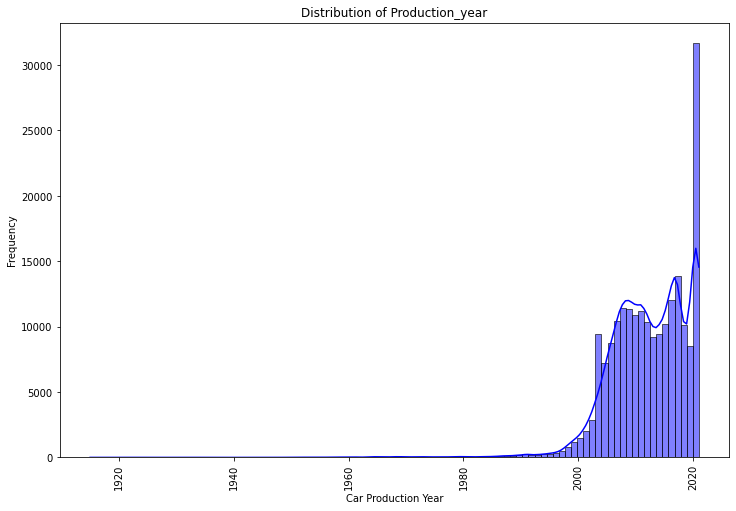

In [20]:
skew = plot_hist(car_sales_df,'Production_year',100,'Car Production Year',kde=True)

**The distribution of production year has negative skew.This indicates most of the car listings are for recent.**

Let's check with the Boxplot

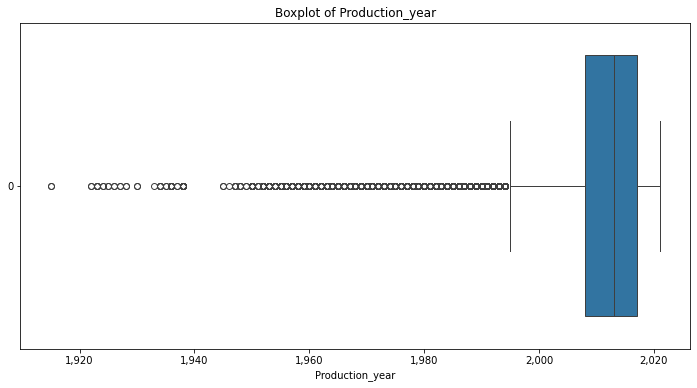

In [21]:
plot_boxplot(car_sales_df,'Production_year')

As we can see, there are quite a few observations that are falling outside of IQR but these observations may not be anomalies since vintage cars have production year quite early in time. Let's cross-check this using IQR operation. 

In [ ]:
col= 'Production_year'
#### For IQR, normally multiplier of 1.5 is standard for most of the cases but here, if we use 1.5, cars that are produced post 1990 would be marked as outlier since the range of Production_year is quite
#### vast. Thus we need to increase width of IQR range to spot accurate vintage outliers

production_year_outliers,upper_bound,lower_bound = perform_IQR(car_sales_df,col,multiplier=2.0)  

print('Total Number of Outliers:',len(production_year_outliers))
print('% Of Data Points Out of Total That Are Outliers:',round((len(production_year_outliers)/len(car_sales_df))*100,2),'%')
print('Minimum Production Year of Outlier Data-Point:',production_year_outliers[col].min())
print('Maximum Production Year of Outlier Data-Point:',production_year_outliers[col].max())

Total Number of Outliers: 1712
% Of Data Points Out of Total That Are Outliers: 0.82 %
Minimum Production Year of Outlier Data-Point: 1915
Maximum Production Year of Outlier Data-Point: 1989


Now Let's confirm our hypothesis with Price vs Production Year Plot

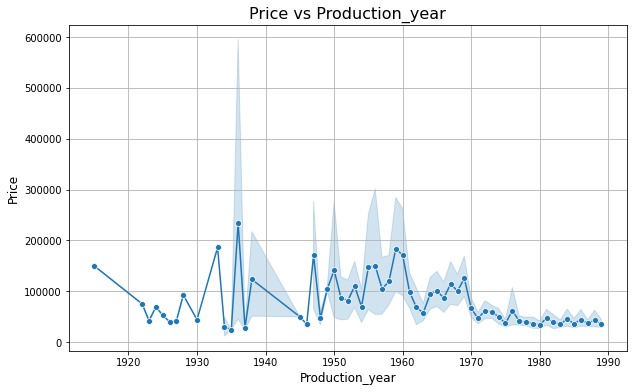

In [23]:
plot_line(production_year_outliers,'Production_year','Price')

As we can see, as the production year approaches 1990s, the prices are quite consistent and low as compared to 1920s-1970s. There's overall downward trend with lots of fluctuations between 1920s-1970s & steady decline post 1980s.

**Conclusion** - The production year column has some outliers in terms of vintage & classic cars manufactured between 1920s-1970s but we flagging them as anomalies doesn't make sense since production year is inherent property of car & we would use it further down analysis as base feature for perfoming anomaly detection on rest of the features.

##### First Registration Date

Now let's move on to the First Registration Date. This column is crucial since this date indicates when did the car first registered to be used on streets. This column has around **60%** nulls or missing entries.

Both *'First_registration_date'* & *'Offer_publication_date'* are in string format, so first we would need to convert them in date-time format to analyze & also engineer meaningful features.


In [24]:
#### converting 'First_registration_date' & 'Offer_publication_date' to date-time for further analysis

car_sales_df['First_registration_date'] = pd.to_datetime(car_sales_df['First_registration_date'], format='%d/%m/%Y',errors='coerce')
car_sales_df['Offer_publication_date'] = pd.to_datetime(car_sales_df['Offer_publication_date'], format='%d/%m/%Y',errors='coerce')

#### Extracting registration year 
car_sales_df['first_registration_year'] = car_sales_df['First_registration_date'].dt.year

#### Calculating gap between production year & registration year. This feature would provide useful signal to spot anomalies in registration date column 
car_sales_df['prod_reg_gap'] = car_sales_df['first_registration_year'] - car_sales_df['Production_year']

First let's see overall distribution of registration year to spot any apparent anomalies

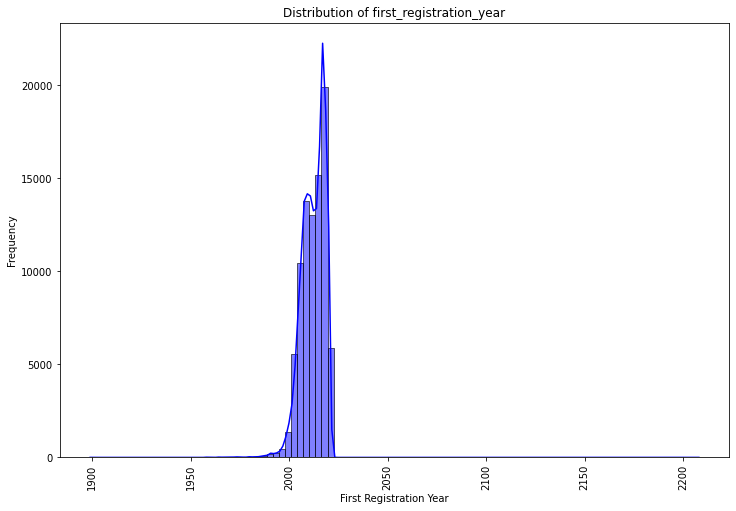

In [25]:
# Plot histogram
skew = plot_hist(car_sales_df,'first_registration_year',100,'First Registration Year',kde=True,formatter=False)

As we can see, there are registration year that are well into the future (post 2021). These are clearly anomalies since the dataset was created in 2021 & the latest ad is from May 2021. So we can safely flag any registration year post 2021 as anomaly.

But that's not all, for rest of the observations during or prior to 2021, there might be some anomalies/outliers. For example, the registration year cannot be prior to production year. Similary, the gap between registration year & production year should fall within normal timeframe (1-3 years). Here, our engineered feature **prod_reg_gap** will come into play. The value for this should be positive since it's difference of registration year & production year.

To mark these anomalies, we would first need to get outlier for the prod_reg_gap column to see the distribution.

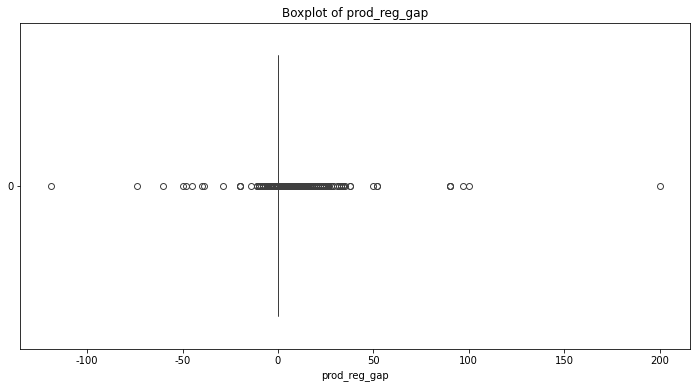

In [26]:
plot_boxplot(car_sales_df,'prod_reg_gap')

As we can see, there are 2 anomalies here:
- Positive gap: This is natural since difference between registration year - production year should always be positive but it can't be more than 1-3 year max unless cars are vintage/antiq
- Negative gap: These are outright anomalies and potential fraudulent entries

In [27]:
car_sales_df[car_sales_df['prod_reg_gap']!=0]['prod_reg_gap'].describe()

count   14754.000
mean        2.845
std         5.050
min      -119.000
25%         1.000
50%         1.000
75%         2.000
max       200.000
Name: prod_reg_gap, dtype: float64

As we can see, there are quite a lot of negative datapoints for the gap, these are clearly anomalies. Moreover, if we remove zeros (since these are not anomalies), most of the gap observations fall within 1-2 year. Thus, we can safely mark gap between 0-3 years as non-anomalies.

Additionally, 60% of data for this column is missing so we would add binary missing indicator

Now to indicate the column has anomalies & missing entries, we will add 2 features:

- Missing column: to flag in entry was missing & we imputed it
- Anomaly column: to flag that the entry might be an anomaly

These columns will act supporting features

In [28]:
car_sales_df['missing_registration_date'] = car_sales_df['First_registration_date'].isnull().astype(int)

#### Flag anomalies in data where first registration date is non-missing. For rest, the gap should be null 
missing_reg_date = car_sales_df[car_sales_df['missing_registration_date']==1]
non_missing_reg_date = car_sales_df[car_sales_df['missing_registration_date']==0]

In [29]:
#### Create New Column To Flag Potential Registration Date Anomalies 

non_missing_reg_date['registration_date_anomaly'] = ((non_missing_reg_date['prod_reg_gap'] < 0) | (non_missing_reg_date['prod_reg_gap'] > 3)).astype(int)
missing_reg_date['registration_date_anomaly'] = np.nan

car_sales_df = pd.concat([missing_reg_date, non_missing_reg_date], axis=0)

##### Offer Publication Date

Offer Publication Date is the data when offer was put on the website.

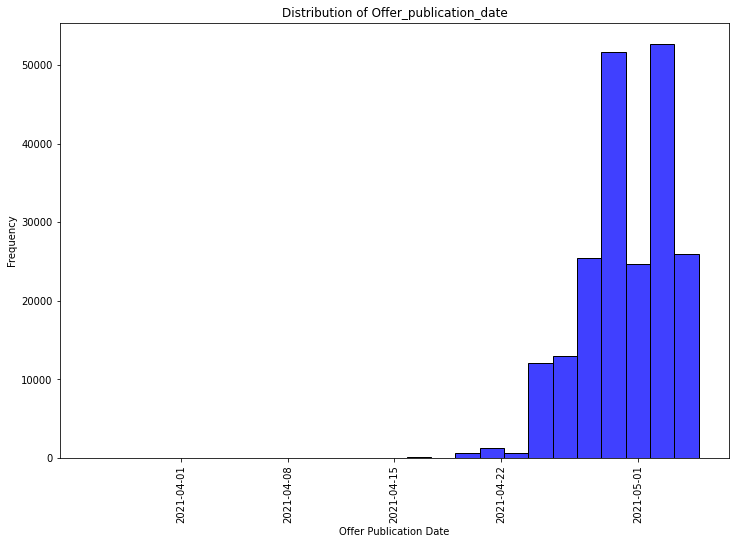

In [30]:
# Plot histogram
skew = plot_hist(car_sales_df,'Offer_publication_date',25,'Offer Publication Date',formatter=False)

This is most straightforward columns. We see that the oldest Ad is from late March early April & the newest Ad is from May 2021. We can make hypothesis that the Car Sale website was lauched in March 2021 & hence intially there were less Ads but as website started becoming popular, the traffic & Ad postings grew.

### Numerical Columns

#### Price

This is the most important column from the dataset since it represents value for the vehicle. 

We see the price is in 2 currencies, to make is simple for distibution, we will convert Euro to PLN since 99% of Ads are in PLN

In [31]:
car_sales_df['Uniform_Price'] = np.where(car_sales_df['Currency']=='PLN',car_sales_df['Price'],car_sales_df['Price']*4.5)

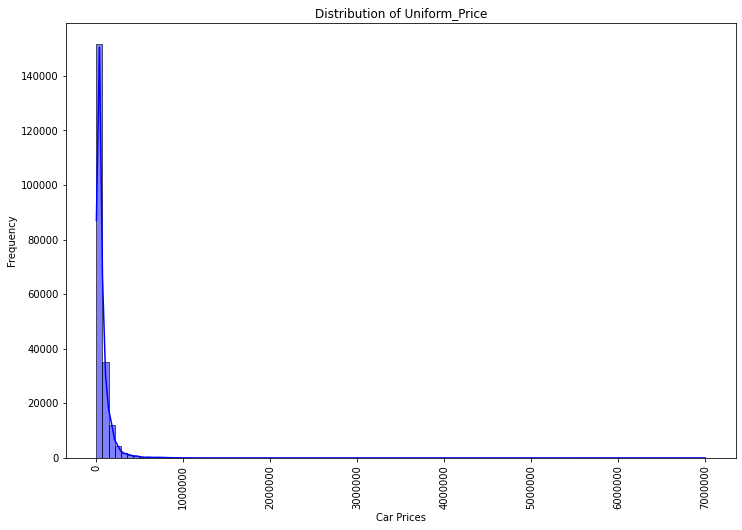

In [32]:
skew = plot_hist(car_sales_df,'Uniform_Price',100,'Car Prices',kde=True,formatter=True,skewness=True)

**As we can see from the plot, the car price distribution is highly right-skewed distribution or positively skewed distribution. The distribution has inflated tail which strongly indicates outliers/anomalies. Let's check with the statistical value**

In [33]:
print("Car Price Skewness:",skew)

Car Price Skewness: 9.200201562848518


**The Skew Value of 9.2 confirms the extreme right-skewed distribution for the car prices. The high values pulling the distribution to the right are most likely outliers**

**Let's do boxplot visual inspection for better understanding**

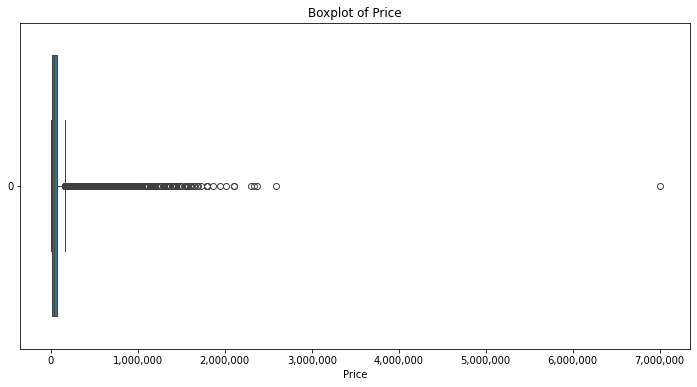

In [34]:
plot_boxplot(car_sales_df,'Price')

**As we can see, there are few outliers post 1,000,000 that are causing right-skewness in the data & there's one extreme outlier that might be the max value for the Price column**

Let's do preliminary outlier detection using IQR Method with 2.5 as multiplier since our distribution is so highly skewed.

In [ ]:
col= 'Price'
car_price_outliers,upper_bound,lower_bound = perform_IQR(car_sales_df,col,multiplier=2.5)

print('Total Number of Outliers:',len(car_price_outliers))
print('% Of Data Points Out of Total That Are Outliers:',round((len(car_price_outliers)/len(car_sales_df))*100,2),'%')
print('Minimum Price of Outlier Data-Point:',car_price_outliers[col].min())
print('Maximum Price of Outlier Data-Point:',car_price_outliers[col].max())

Total Number of Outliers: 8464
% Of Data Points Out of Total That Are Outliers: 4.06 %
Minimum Price of Outlier Data-Point: 221499
Maximum Price of Outlier Data-Point: 6999000


**As we can see the first outlier is at 2,21,499 which is well beyond 75th percentile & maximum is highest value for the Price Column. This fits the bill for all the 16,541 datapoints being outliers.**

Let's examine these outliers even further with price vs production year plot 

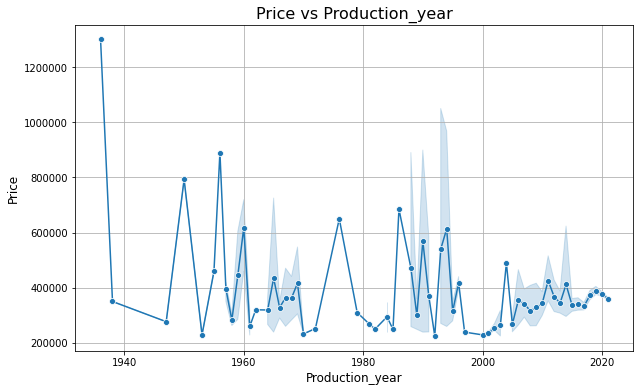

In [36]:
plot_line(car_price_outliers,'Production_year','Price')

As we can see, there is huge fluctuation with higher prices for cars manufactured prior to 2000. These cars would most probably be vintage, antiq & classics.
But there's catch here, not all cars prior to 2000s are highly priced. Thus, older manufacturing year doesn't directly correlate to higher price. The car model, condition, brand and other factors will play role. For time being we will flag these outliers anomalies.

We will use 221499 as a threshold to flag anomaly in price as per IQR operation

In [37]:
car_sales_df['price_anomaly'] = np.where(car_sales_df['Price']>221499,1,0)

#### Mileage

Mileage_km shows distance covered by cars. Ideally, for New cars, it should be close to zero. 

Plus, we would engineer new feature called 'Car Age' since it might have strong correlation with Miles covered. Car age is difference between Production year & Ad Publication year i.e. 2021.

Let's examine

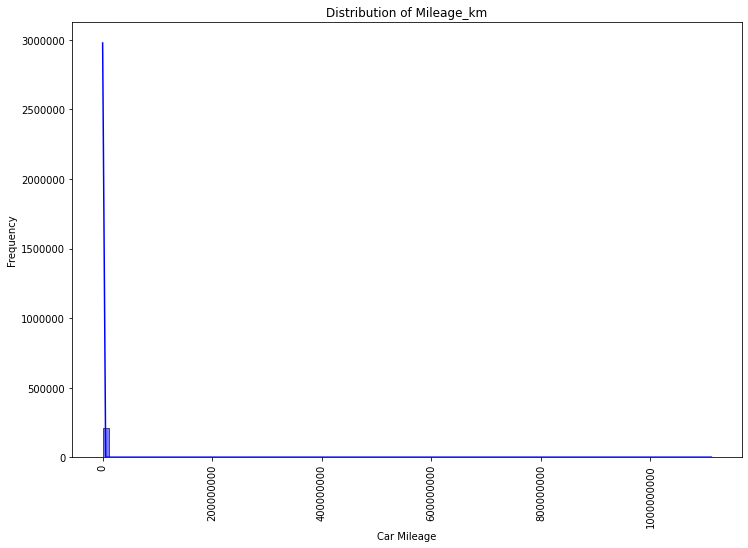

In [38]:
car_sales_df['car_age'] = 2021 - car_sales_df['Production_year']
skew = plot_hist(car_sales_df,'Mileage_km',100,'Car Mileage',kde=True,skewness=True)

There are some abnormally high values that are inflating the the tail of the distribution. These values are clearly anomalies. Let's use boxplot.

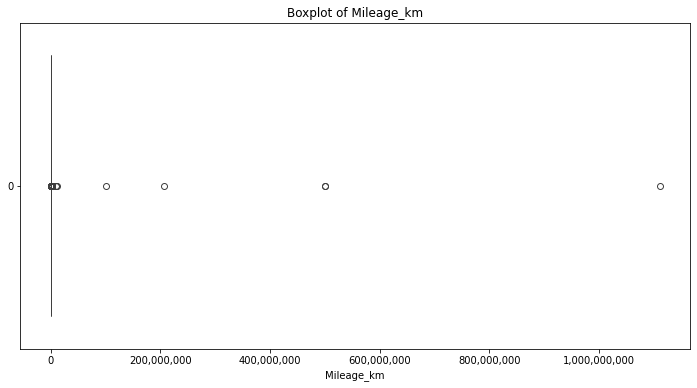

In [39]:
plot_boxplot(car_sales_df,'Mileage_km')

At this point we can do IQR analysis to get outliers. But first we need to separate Used cars from New cars so that our analysis is accurate & also potentially mark anomalies

In [40]:
car_sales_df.groupby(['Condition'])['Mileage_km'].describe().reset_index()

,Condition,count,mean,std,min,25%,50%,75%,max
0,New,24471.000,101.422,828.145,1.000,1.000,5.000,7.000,53867.000
1,Used,182850.000,170374.881,3127291.347,1.000,91000.000,160000.000,215000.000,1111111111.000


As we can see, for New cars, the 75th percentile is still around 0 but it has anomalies like 53867.

Similarly, for Used cars, the minimum cannot be 0 & maximum cannot be so abnormal

In [41]:
car_sales_df_used = car_sales_df[car_sales_df['Condition']=='Used']
car_sales_df_new = car_sales_df[car_sales_df['Condition']=='New']

Let's see IQR for new cars

In [42]:
### IQR for New cars
col= 'Mileage_km'
car_mile_outliers_new,upper_bound,lower_bound = perform_IQR(car_sales_df_new,col)

print('Total Number of Outliers:',len(car_mile_outliers_new))
print('% Of Data Points Out of Total That Are Outliers:',round((len(car_mile_outliers_new)/len(car_sales_df))*100,2),'%')
print('Minimum Mileage of Outlier Data-Point:',car_mile_outliers_new[col].min())
print('Maximum Mileage of Outlier Data-Point:',car_mile_outliers_new[col].max())

Total Number of Outliers: 1406
% Of Data Points Out of Total That Are Outliers: 0.67 %
Minimum Mileage of Outlier Data-Point: 17.0
Maximum Mileage of Outlier Data-Point: 53867.0


As we can see, for the New cars, there's non-zero mileage which looks implausible.

In [ ]:
### IQR for used cars
col= 'Mileage_km'
car_mile_outliers_used,upper_bound,lower_bound = perform_IQR(car_sales_df_used,col,2.5)

print('Total Number of Outliers:',len(car_mile_outliers_used))
print('% Of Data Points Out of Total That Are Outliers:',round((len(car_mile_outliers_used)/len(car_sales_df))*100,2),'%')
print('Minimum Mileage of Outlier Data-Point:',car_mile_outliers_used[col].min())
print('Maximum Mileage of Outlier Data-Point:',car_mile_outliers_used[col].max())

Total Number of Outliers: 171
% Of Data Points Out of Total That Are Outliers: 0.08 %
Minimum Mileage of Outlier Data-Point: 527381.0
Maximum Mileage of Outlier Data-Point: 1111111111.0


For Used cars, most cars retire after hitting mileage of 300000. Here the outliers are well past that mark.

Similar to earlier, we will create column to flag missing entries & anomalies

In [44]:
car_sales_df['missing_mileage'] = car_sales_df['Mileage_km'].isnull().astype(int)

#### Flag anomalies in data where Mileage is non-missing.
missing_mileage = car_sales_df[car_sales_df['missing_mileage']==1]
non_missing_mileage = car_sales_df[car_sales_df['missing_mileage']==0]

In [45]:
car_sales_df_used = non_missing_mileage[non_missing_mileage['Condition']=='Used']
car_sales_df_new = non_missing_mileage[non_missing_mileage['Condition']=='New']


#### Create New Column To Flag Potential Mileage Date Anomalies 
car_sales_df_new['mileage_anomaly'] = ((car_sales_df_new['Mileage_km'] > 17)).astype(int)
car_sales_df_used['mileage_anomaly'] = ((car_sales_df_used['Mileage_km'] > 527381)).astype(int)

non_missing_mileage = pd.concat([car_sales_df_new,car_sales_df_used],axis=0)

missing_mileage['mileage_anomaly'] = np.nan
car_sales_df = pd.concat([missing_mileage, non_missing_mileage], axis=0)


#### Power HP

Power HP is engine's horsepower. This heavily depends on car type. We will examine trend within each car type group & spot anomalies.

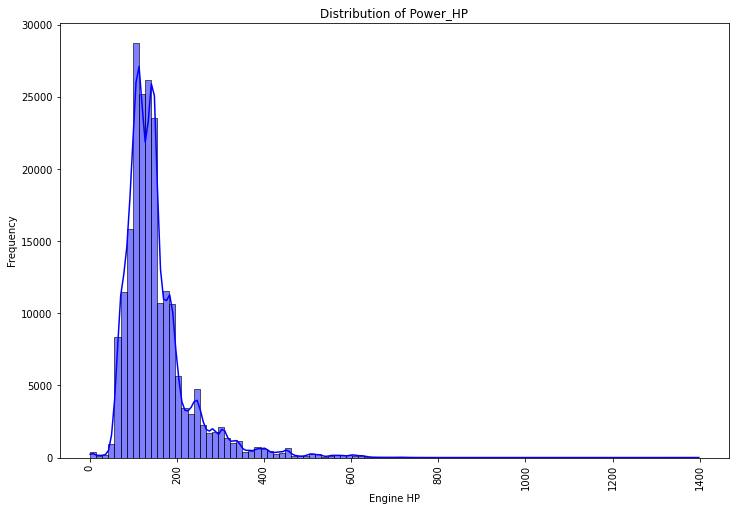

In [46]:
skew = plot_hist(car_sales_df,'Power_HP',100,'Engine HP',kde=True,formatter=True,skewness=True)

As we can see, the distribution isn't highly skewed as compared to other variables. Though there are some apparent outliers. These are most likely heavy duty vehicles or luxury high performance cars. For this we would need to see distribution for each group within Type column.

Plotting Box-Plot & performing IQR check won't help here since we need to examine each vehicle type separately & spot anomalies.

In [47]:
### Let's see the Power values for each car types

cars_hp = car_sales_df.groupby(['Type'])['Power_HP'].describe().reset_index()
cars_hp[['Type','min','max']]

,Type,min,max
0,SUV,1.000,1300.000
1,city_cars,1.000,1111.000
2,compact,1.000,907.000
3,convertible,1.000,721.000
4,coupe,1.000,800.000
5,minivan,1.000,1203.000
6,sedan,1.000,1398.000
7,small_cars,1.000,698.000
8,station_wagon,1.000,1111.000


For all the types, the minimum value is 1 that doesn't make any sense. Here are normal ranges for given vehicle types:

- SUV	100–700+ HP (performance SUVs exceed 700)
- City Cars	50–120 HP
- Compact	50–250 HP
- Convertible	100–450+ HP
- Coupe	100–500+ HP (higher for sports variants)
- Minivan	120–300 HP
- Sedan	100–400+ HP (luxury models go higher)
- Station Wagon	120–300+ HP
- Small Cars	50–150 HP

Based on this we will set conditions & mark anomalies

Similar to earlier, we will create column to flag missing entries & anomalies

In [48]:
car_sales_df['missing_hp'] = car_sales_df['Power_HP'].isnull().astype(int)

#### Flag anomalies in data where HP is non-missing.
missing_hp = car_sales_df[car_sales_df['missing_hp']==1]
non_missing_hp = car_sales_df[car_sales_df['missing_hp']==0]

In [49]:
conditions = {
    'coupe': range(90, 700),
    'convertible': range(90, 500),
    'minivan': range(100, 400),
    'sedan': range(90,700),
    'SUV': range(90, 1000),
    'city_cars': range(50, 130),
    'station_wagon': range(100,500),
    'compact': range(50, 260),
    'small_cars': range(50,150)
}
# Create the 'door_num_anomaly' column
non_missing_hp['hp_anomaly'] = non_missing_hp.apply(lambda row: 1 if row['Power_HP'] not in conditions.get(row['Type'], []) else 0,axis=1)

missing_hp['hp_anomaly'] = np.nan
car_sales_df = pd.concat([missing_hp, non_missing_hp], axis=0)

**The engine power is slighly less skewed than thr othet two (Price & Mileage) columns. Still this column too has upper & lower bound outliers. The minimum value of 1 doesn't make sense for the engine power & most likely is outlier**

#### Displacement

Displacement is engine's capacity measured in CC. This one is heavily dependent on vehicle type & fuel type

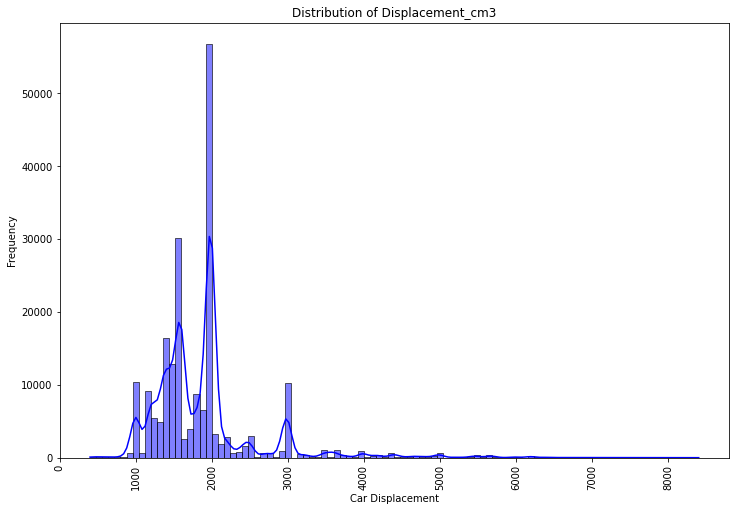

In [50]:
skew = plot_hist(car_sales_df,'Displacement_cm3',100,'Car Displacement',kde=True,formatter=True,skewness=True)

Similar to Power_hp columns, the distribution isn't highly skewed as compared to other variables. Though there are some apparent outliers. These are most likely heavy duty vehicles or luxury high performance cars. Moreover, electic vehicles do not have engine so their dispacemet values should be null.

Plotting Box-Plot & performing IQR check on overall data won't help here since we need to examine each vehicle type separately & spot anomalies.

Based on vehicle types, these are broader ranges across fuel types:

- Coupe: 1,000-4,000
- Convertible: 1,000-4,000
- Minivan: 1,500-3,500
- Sedan: 1,000-5,000
- SUV: 1,200-6,000
- City Cars: 600-1,500
- Station Wagon: 1,200-3,500
- Compact: 1,000-2,500 
- Small Cars: 600-1,800

As displacement is tied to Car Type, let's see the distribution across various types

In [51]:
car_cc = car_sales_df.groupby(['Type'])['Displacement_cm3'].describe().reset_index()
car_cc[['Type','min','max']]

,Type,min,max
0,SUV,400.000,7300.000
1,city_cars,400.000,5272.000
2,compact,400.000,7000.000
3,convertible,500.000,8285.000
4,coupe,400.000,8200.000
5,minivan,875.000,7600.000
6,sedan,400.000,8190.000
7,small_cars,400.000,8400.000
8,station_wagon,595.000,7400.000


Similar to earlier, we will create column to flag missing entries & anomalies

In [52]:
car_sales_df['missing_disp'] = car_sales_df['Displacement_cm3'].isnull().astype(int)

#### Flag anomalies in data where Displacement is non-missing.
missing_cc = car_sales_df[car_sales_df['missing_disp']==1]
non_missing_cc = car_sales_df[car_sales_df['missing_disp']==0]

In [53]:
conditions = {
    'coupe': range(900, 4100),
    'convertible': range(900, 4100),
    'minivan': range(1500, 4000),
    'sedan': range(900,5100),
    'SUV': range(1200, 6100),
    'city_cars': range(600, 1600),
    'station_wagon': range(1200,3600),
    'compact': range(900, 2600),
    'small_cars': range(600,2000)
}
# Create the 'door_num_anomaly' column
non_missing_cc['cc_anomaly'] = non_missing_cc.apply(lambda row: 1 if row['Displacement_cm3'] not in conditions.get(row['Type'], []) else 0,axis=1)

missing_cc['cc_anomaly'] = np.nan
car_sales_df = pd.concat([missing_cc, non_missing_cc], axis=0)

**The Displacement column measures enginer size and may have some outliers. The minimum value of 400 looks suspicious since most microcars have engine size as small as 400. The values higher than 4000 are for sports cars or performance vehicles. Further inspection is needed**

#### CO2 Emissions 

CO2 Emission column has one of the most missing value counts from data, around 55% of data is missing. Usually older cars models have higher emissions than the modern cars. Let's examine

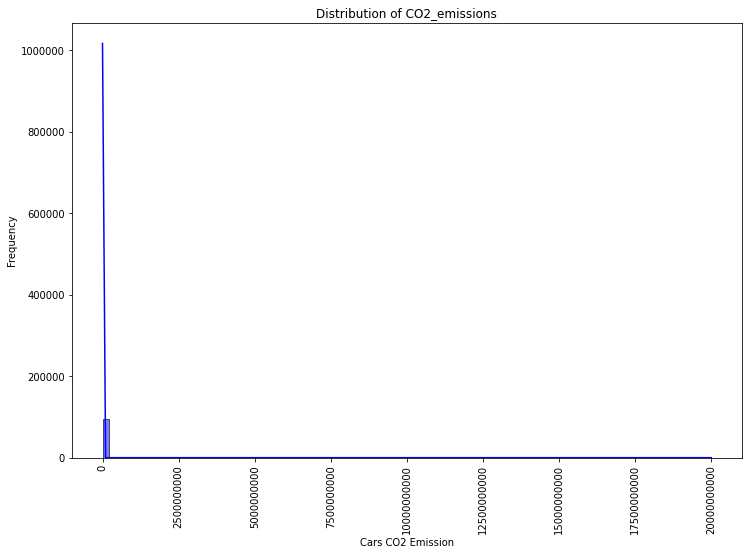

In [54]:
skew = plot_hist(car_sales_df,'CO2_emissions',100,'Cars CO2 Emission',kde=True,formatter=True,skewness=True)

As expected, the distribution is highly skewed owing to extreme outliers. Let's check these outliers using box-plot

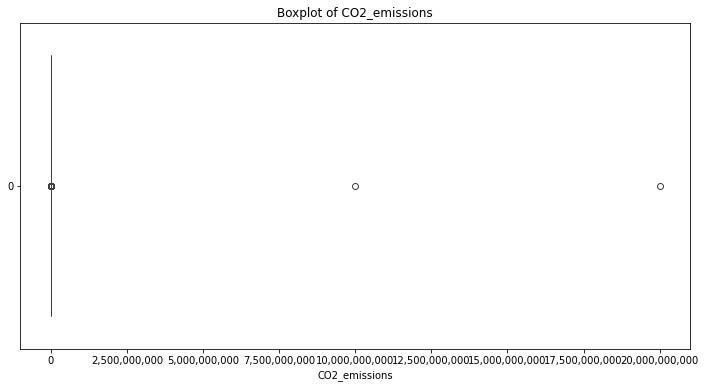

In [55]:
plot_boxplot(car_sales_df,'CO2_emissions')

As we can see, there are a few extreme outliers that have inflated the data.

In [56]:
car_sales_df['CO2_emissions'].describe()

count         94047.000
mean         319156.381
std        72913958.705
min               1.000
25%             120.000
50%             140.000
75%             164.000
max     20000000000.000
Name: CO2_emissions, dtype: float64

The 75th percentile for emission is 164 & highest value is 20000000000. This is definitely anomaly. Let's set 1000 as threshold & re-visualize box-plot

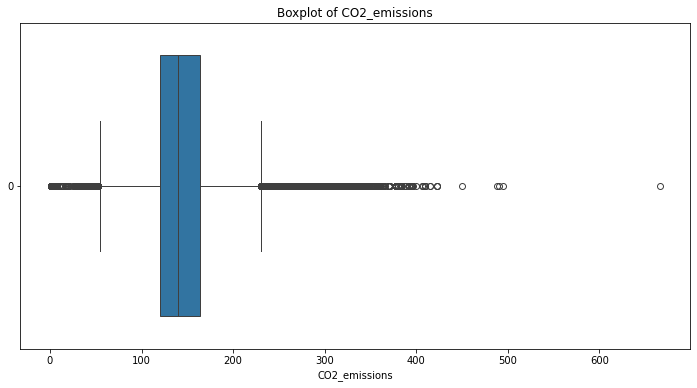

In [57]:
df_temp = car_sales_df[car_sales_df['CO2_emissions']<10000]

plot_boxplot(df_temp,'CO2_emissions')

This is much better & we can see the IQR as well as outliers.

In [58]:
col= 'CO2_emissions'
car_emission_outliers,upper_bound,lower_bound = perform_IQR(df_temp,col)

print('Total Number of Outliers:',len(car_emission_outliers))
print('% Of Data Points Out of Total That Are Outliers:',round((len(car_emission_outliers)/len(car_sales_df))*100,2),'%')
print('Minimum Emission of Outlier Data-Point:',car_emission_outliers[col].min())
print('Maximum Emission of Outlier Data-Point:',car_emission_outliers[col].max())

Total Number of Outliers: 4665
% Of Data Points Out of Total That Are Outliers: 2.24 %
Minimum Emission of Outlier Data-Point: 1.0
Maximum Emission of Outlier Data-Point: 666.0


Based on above, it's evident that the lower-bound outliers are closer to 0  while upper bound anomalies start around 666. But there's catch, these values are on overall data & doesn't take into consideration fuel type.

Since engine emission has strong correlation with fuel type, we will use normal ranges for varioud fuel type to flag anomalies as follows:

- Gasoline: 90-250
- Diesel: 100-220
- Electric: 0
- Gasoline + CNG: 90-160 
- Gasoline + LPG: 80-150
- Hybrid: 80-150 
- Hydrogen: 0  
- Ethanol: 100 - 200 

Similar to earlier, we will create column to flag missing entries & anomalies

In [59]:
car_sales_df['missing_co2'] = car_sales_df['CO2_emissions'].isnull().astype(int)

#### Flag anomalies in data where Emission is non-missing.
missing_co2 = car_sales_df[car_sales_df['missing_co2']==1]
non_missing_co2 = car_sales_df[car_sales_df['missing_co2']==0]

In [60]:
conditions = {
    'Gasoline': range(90, 260),
    'Diesel': range(90, 250),
    'Electric': [0],
    'Gasoline + CNG': range(90,170),
    'Gasoline + LPG': range(80, 160),
    'Hybrid': range(80, 160),
    'Hydrogen': [0],
    'Ethanol': range(100, 200)
}
# Create the 'door_num_anomaly' column
non_missing_co2['co2_anomaly'] = non_missing_co2.apply(lambda row: 1 if row['CO2_emissions'] not in conditions.get(row['Fuel_type'], []) else 0,axis=1)

missing_co2['co2_anomaly'] = np.nan
car_sales_df = pd.concat([missing_co2, non_missing_co2], axis=0)

## Negative Values Check

For the last sanity check, we will check numerical columns for any negative values

In [61]:
car_sales_num_col_df = car_sales_df[num_cols]

negative_rows = car_sales_num_col_df[(car_sales_num_col_df < 0).any(axis=1)]

print('Row Count With Negative',len(negative_rows))

Row Count With Negative 0


There are no negative values in dataset as expected

## Null Value Replacement

Now, we will perform imputation on the columns where there are missing values or nulls. There are 12 columns with Nulls. Out of the 12, following columns could be easily imputed since these are categorical columns with little to no anomalies.

- First_owner 
- Origin_country
- Vehicle_version -> no chance => vehicle brand & model have no null so no chance for anamoly => mode of group
- Vehicle_generation -> no chance => mode of group
- Drive -> low chance -> replace with mode of group
- Transmission -> mode of group

For First Owner, we will replace null with 'Missing'. For rest of the above, we will impute missing values based on mode of the group

For Origin Country,vehicle version & generation, we will do imputation based on vehicle brand & model

For Drive & Transmission, we will use brand, model, fuel type & car type

In [62]:
#### For Drive & Transmission, we will add binary missing indicator since it will provide signal for further analysis
car_sales_df['missing_drive'] = car_sales_df['Drive'].isnull().astype(int)
car_sales_df['missing_tranm'] = car_sales_df['Transmission'].isnull().astype(int)

In [63]:
car_sales_df['First_owner'] = car_sales_df['First_owner'].fillna('Missing')

for col in ['Origin_country', 'Vehicle_version', 'Vehicle_generation', 'Doors_number']:    
    car_sales_df[col] = car_sales_df.groupby(['Vehicle_brand', 'Vehicle_model'])[col].transform(fill_with_mode) # Apply the function group-wise

In [64]:
group_lis = ['Vehicle_brand','Vehicle_model','Fuel_type','Type']

for col in ['Drive','Transmission']:
    car_sales_df[col] = car_sales_df.groupby(group_lis)[col].transform(fill_with_mode) # Apply the function group-wise

For the following columns, we would need to do imputation based on various groups since these columns are where most of the anomalies have been observed

- First_registration_date 
- CO2_emissions 
- Displacement_cm3
- Mileage_km 
- Power_HP

For First Registration Date, we would use Vehicle Brand, Model & Production Year

For Displacement, Power_HP, Co2_emission & Doors_number, we will use Vehicle Brand, Model, Fuel_type, Type

For Mileage_km, we will use Vehicle Brand, Model, Condition, Type

In [65]:
group_lis = ['Vehicle_brand','Vehicle_model','Production_year']

global_median = car_sales_df['First_registration_date'].median() #### calculate median of full column, in case of group of all nans, we replace missing value with global median
car_sales_df['First_registration_date'] = car_sales_df.groupby(group_lis)['First_registration_date'].transform(lambda x: x.fillna(x.median() if not x.isna().all() else global_median))

In [66]:
group_lis = ['Vehicle_brand','Vehicle_model','Fuel_type', 'Type']

for col in ['Displacement_cm3','Power_HP','CO2_emissions']:
    
    global_median = car_sales_df[col].median() #### calculate median of full column, in case of group of all nans, we replace missing value with global median
    car_sales_df[col] = car_sales_df.groupby(group_lis)[col].transform(lambda x: x.fillna(x.median() if not x.isnull().all() else global_median))

In [67]:
group_lis = ['Vehicle_brand','Vehicle_model','Condition', 'Type'] 
col = 'Mileage_km'
global_median = car_sales_df[col].median() #### calculate median of full column, in case of group of all nans, we replace missing value with global median
car_sales_df[col] = car_sales_df.groupby(group_lis)[col].transform(lambda x: x.fillna(x.median() if not x.isnull().all() else global_median))

## Analyze Anomalies

Now we come to the important part of analyzing anomalies based on trends we saw & features we created. Before jumping into analysis, we will do some last data preprocessing for remaining columns

In [68]:
#### Create registration year & prod-registration gap for imputed features

car_sales_df['first_registration_year'] = car_sales_df['First_registration_date'].dt.year
car_sales_df['prod_reg_gap'] = car_sales_df['first_registration_year'] - car_sales_df['Production_year']

#### convert from string to int
car_sales_df['Doors_number'] = car_sales_df['Doors_number'].replace('None', 0).astype('int64')

Most of our numerical features are on varying scales, for example, price of car in PLN/Euro with average of 63053 PLN & Number of Doors are single or double digits. We would need all of these features to have a common scale that ensures that all features contribute equally to the clustering process, regardless of their original range or units. So we would do **Feature Scaling.**

Moreover, most of the numerical features (Price, Mileage & Emissions) are highly skewed. If a feature has a highly right-skewed distribution, applying a log transformation can make the distribution closer to normal. This reduces the influence of extreme values (outliers) on the algorithms we test. Hence we would do **Log Transformation.**

**Finally, we would also convert relevant categorical features into numerical using one-hot encoding.**


In [69]:
col_lis = ['Condition','Type']
car_sales_df_dummies = pd.get_dummies(car_sales_df, columns=col_lis)


#### Dropping irrelevant columns
cols_to_drop = ['Colour','First_registration_date','Offer_publication_date','Offer_location','Uniform_Price','Features','Vehicle_version','Vehicle_generation','Vehicle_brand','Vehicle_model',
                'Origin_country','First_owner','Drive','Transmission','Fuel_type','Origin_country','Currency']

car_sales_df_final_features = car_sales_df_dummies.drop(columns=cols_to_drop)

Before we do anomaly detection, we would need to separate imputed observations from original data. This is important because if we use any anomaly detection algorithm on entire dataset, there are two risks:

**Bias in the Imputed Data**: Imputed values are estimated based on the available data and assumptions made during the imputation process. If you mix imputed data with original data, the model might treat imputed values as equally valid, which could skew the results, especially if the imputation model was not very accurate.

**Detection of False Positives or False Negatives**: Anomaly detection algorithms may identify imputed values as outliers, especially if the imputation method does not reflect the true distribution of the data. This could lead to false positives (imputed values flagged as anomalies) or false negatives (real anomalies in original data overlooked).

In [70]:
cols_ind_miss_rows = ['missing_doors_number','missing_registration_date', 'missing_mileage', 'missing_hp','missing_disp', 'missing_co2', 'missing_drive', 'missing_tranm']

rows_with_missing_features = car_sales_df_final_features[car_sales_df_final_features[cols_ind_miss_rows].sum(axis=1) > 0]
rows_with_complete_features = car_sales_df_final_features[car_sales_df_final_features[cols_ind_miss_rows].sum(axis=1)==0]

In [71]:

# List of features to be scaled and log-transformed
features_to_scale = ['Price','car_age', 'Mileage_km','Power_HP','Displacement_cm3', 'CO2_emissions','prod_reg_gap']
features_to_log_transform = ['Price', 'Mileage_km','CO2_emissions']

# 1. **Scaling Features** for consistency across features
scaler = StandardScaler()  # or MinMaxScaler() if you prefer scaling between 0 and 1

scaler.fit(car_sales_df_final_features[features_to_scale])

rows_with_complete_features[features_to_scale] = scaler.transform(rows_with_complete_features[features_to_scale])
rows_with_missing_features[features_to_scale] = scaler.transform(rows_with_missing_features[features_to_scale])

# 2. **Log Transformation** for skewed features
for feature in features_to_log_transform:
    rows_with_missing_features[feature] = rows_with_missing_features[feature].apply(lambda x: np.log1p(x) if x > 0 else 0)
    rows_with_complete_features[feature] = rows_with_complete_features[feature].apply(lambda x: np.log1p(x) if x > 0 else 0)


Now, we will jump into anomaly detection. Here's our approach:

We will treat the flags that we created for each anomalous column as ground truth & evaluate performace of our method against it. In the end, we will compare the observations from both & see if our method was able to capture the anomalies effectively.

We are going to choose Isolation Forest as the algorithm of interest because it is good for anomaly detection since it isolates anomalies by randomly selecting features and splitting the data. Anomalies are easier to isolate as they are few and different from normal data points. This method is efficient, scalable, and works well with high-dimensional data, making it suitable for large datasets.

As compared to DBSCAN, it is less computationally expensive & requires no labels

In [72]:
#### Get list of ground truth column & columns to use as features
gr_truth = ['door_num_anomaly','registration_date_anomaly','price_anomaly','mileage_anomaly','hp_anomaly','cc_anomaly','co2_anomaly']
rows_with_complete_features_scaled = rows_with_complete_features.drop(columns=cols_ind_miss_rows)
cols_to_keep =  list(np.setdiff1d(list(rows_with_complete_features_scaled.columns),gr_truth+['Index']))

Let's run our isolation forest. To do so, we will do fuzz-grid search in terms of finding best contamination parameter. Contamination parameter is how we control number of anomalies we think our dataset will have. For our dataset, since we have anomalies in multiple columns, the count gets higher in the range of 15-20%

In [73]:
random_state = 15

for contamination_param in [0.05,0.10,0.15,0.20,0.25]:
    # Fit and predict on non-imputed data
    model = IsolationForest(contamination=contamination_param, random_state=random_state)
    
    contamination_param = str(contamination_param)

    rows_with_complete_features_scaled['anomaly_score_'+contamination_param] = model.fit_predict(rows_with_complete_features_scaled[cols_to_keep])
    rows_with_complete_features_scaled['anomaly_'+contamination_param] = rows_with_complete_features_scaled['anomaly_score_'+contamination_param].apply(lambda x: 1 if x == -1 else 0)
    print(f"Anomalies detected with contamination={contamination_param}: {sum(rows_with_complete_features_scaled['anomaly_score_'+contamination_param] == -1)}")

    rows_with_complete_features_scaled['labels'] = rows_with_complete_features_scaled[gr_truth].any(axis=1).astype(int)
    
    # Precision: TP / (TP + FP)
    precision = precision_score(rows_with_complete_features_scaled['labels'], rows_with_complete_features_scaled['anomaly_'+contamination_param])

    # Recall: TP / (TP + FN)
    recall = recall_score(rows_with_complete_features_scaled['labels'], rows_with_complete_features_scaled['anomaly_'+contamination_param])

    # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = f1_score(rows_with_complete_features_scaled['labels'], rows_with_complete_features_scaled['anomaly_'+contamination_param])

    print(f"Precision: {round(precision,2)}")
    print(f"Recall: {round(recall,2)}")
    print(f"F1 Score: {round(f1,2)}") 
    print('_'*100)

Anomalies detected with contamination=0.05: 2233
Precision: 0.64
Recall: 0.13
F1 Score: 0.22
____________________________________________________________________________________________________
Anomalies detected with contamination=0.1: 4468
Precision: 0.54
Recall: 0.23
F1 Score: 0.32
____________________________________________________________________________________________________
Anomalies detected with contamination=0.15: 6701
Precision: 0.5
Recall: 0.31
F1 Score: 0.39
____________________________________________________________________________________________________
Anomalies detected with contamination=0.2: 8936
Precision: 0.46
Recall: 0.38
F1 Score: 0.42
____________________________________________________________________________________________________
Anomalies detected with contamination=0.25: 11170
Precision: 0.42
Recall: 0.44
F1 Score: 0.43
____________________________________________________________________________________________________


It looks like, our algorithm perfomed well as we increased contamination. As we go from 20% to 25% there isn't huge improvemnt in F1 score.

For each parameter, we will plot of Price vs Mileage to see how our algoithm performed & spotted anomalies for these 2 features

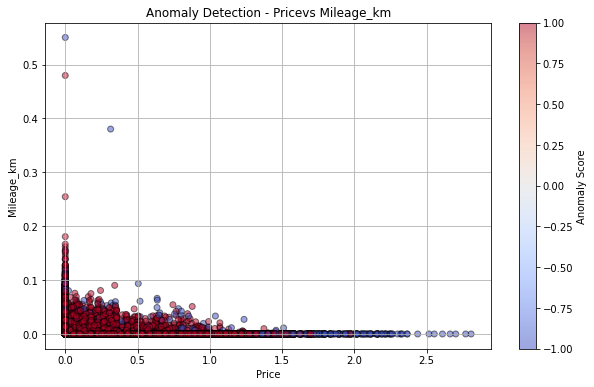

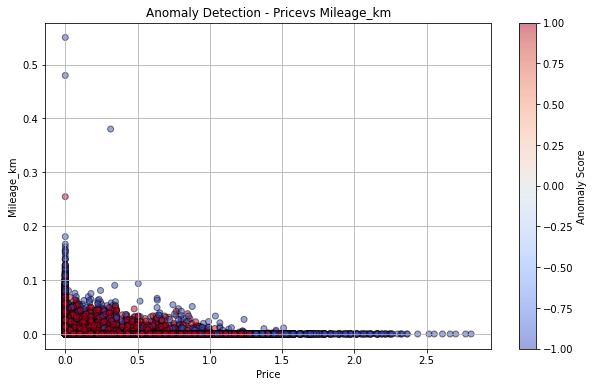

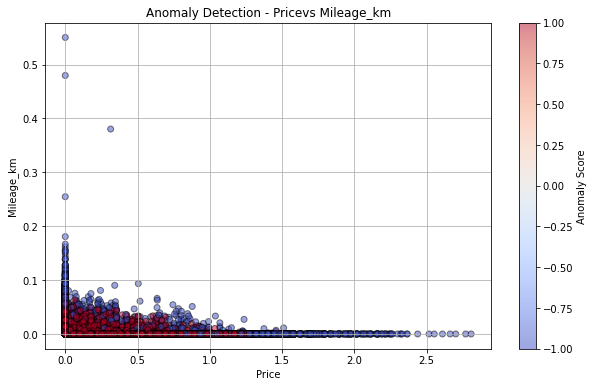

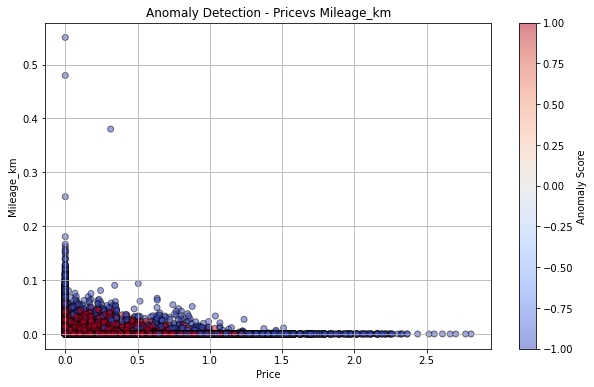

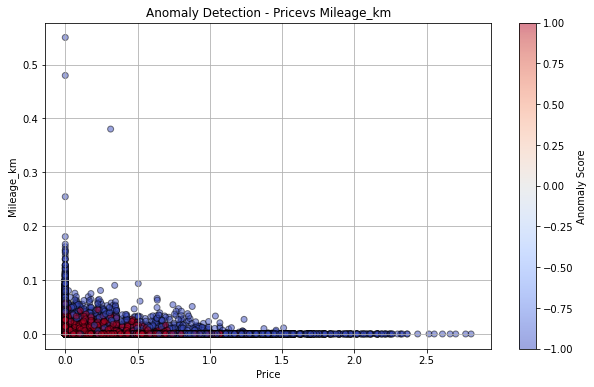

In [74]:
for contamination_param in [0.05,0.10,0.15,0.20,0.25]:
    contamination_param = str(contamination_param)
    plot_scatter(rows_with_complete_features_scaled,'Price','Mileage_km','anomaly_score_'+contamination_param)
    

Finally, we will use PCA to project our high dimentional data in 2D using PCA. This will help us to see how effectively our algorithm managed to spot anomalies

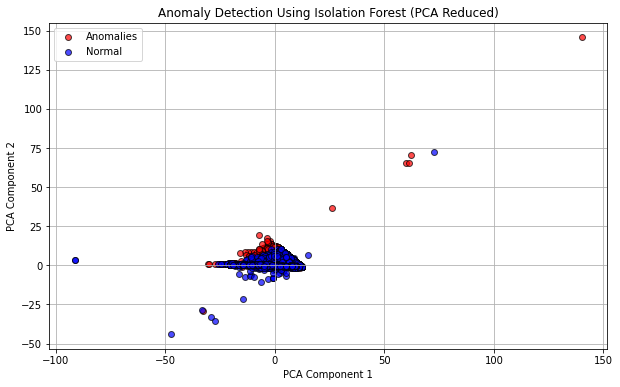

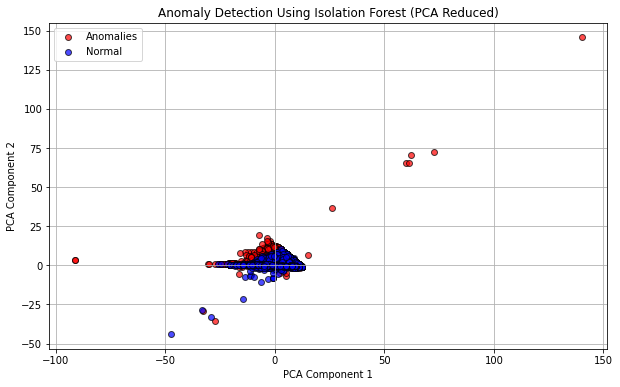

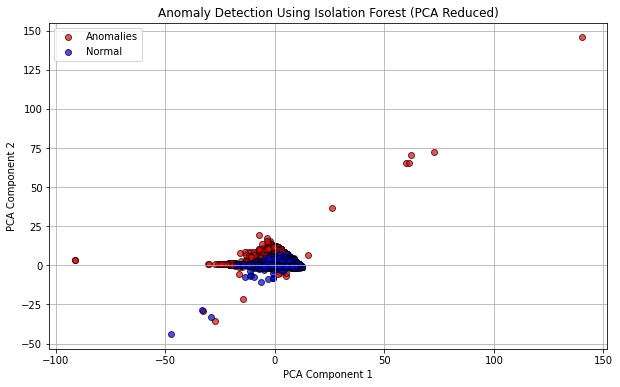

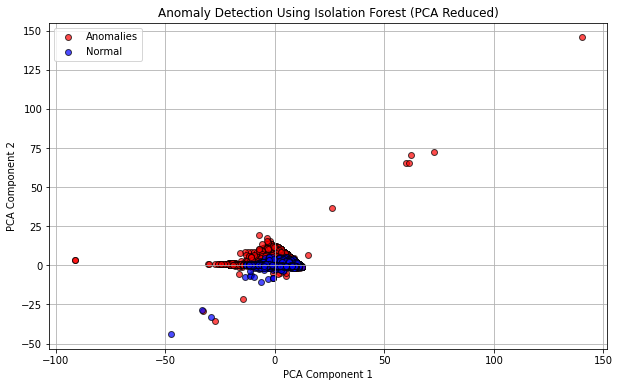

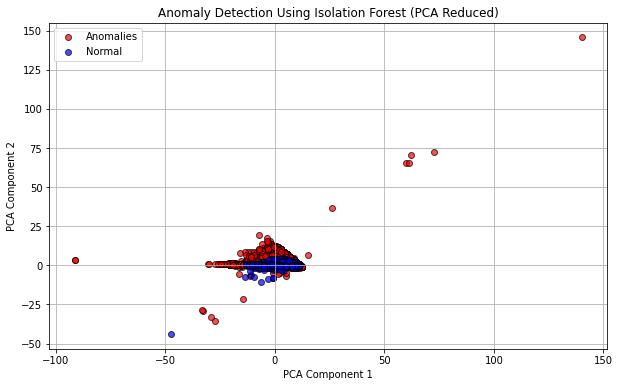

In [75]:
for contamination_param in [0.05,0.10,0.15,0.20,0.25]:
    contamination_param = str(contamination_param)
    plot_pca(rows_with_complete_features_scaled,cols_to_keep,contamination_param)

As we can see, as we increase contamination param more, more extreme points are labelled as anomalies. Let's do same for our imputed data

In [76]:
gr_truth = ['door_num_anomaly','registration_date_anomaly','price_anomaly','mileage_anomaly','hp_anomaly','cc_anomaly','co2_anomaly']
rows_with_missing_features_scaled = rows_with_missing_features.drop(columns=cols_ind_miss_rows)
cols_to_keep =  list(np.setdiff1d(list(rows_with_missing_features_scaled.columns),gr_truth+["Index"]))

In [77]:
random_state = 15

for contamination_param in [0.05,0.10,0.15,0.20,0.25]:
    # Fit and predict on non-imputed data
    model = IsolationForest(contamination=contamination_param, random_state=random_state)
    
    contamination_param = str(contamination_param)

    rows_with_missing_features_scaled['anomaly_score_'+contamination_param] = model.fit_predict(rows_with_missing_features_scaled[cols_to_keep])
    rows_with_missing_features_scaled['anomaly_'+contamination_param] = rows_with_missing_features_scaled['anomaly_score_'+contamination_param].apply(lambda x: 1 if x == -1 else 0)
    print(f"Anomalies detected with contamination={contamination_param}: {sum(rows_with_missing_features_scaled['anomaly_score_'+contamination_param] == -1)}")

Anomalies detected with contamination=0.05: 8182
Anomalies detected with contamination=0.1: 16363
Anomalies detected with contamination=0.15: 24544
Anomalies detected with contamination=0.2: 32725
Anomalies detected with contamination=0.25: 40897


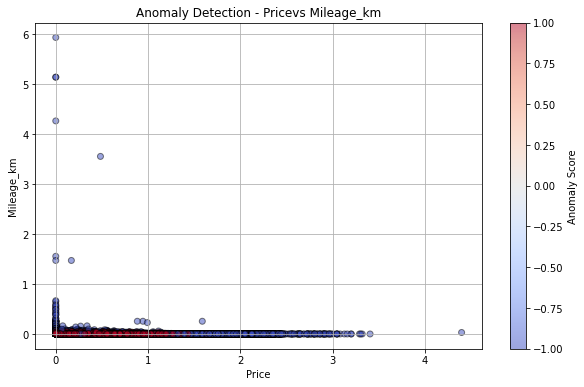

In [80]:
plot_scatter(rows_with_missing_features_scaled,'Price','Mileage_km','anomaly_score_'+str(contamination_param))

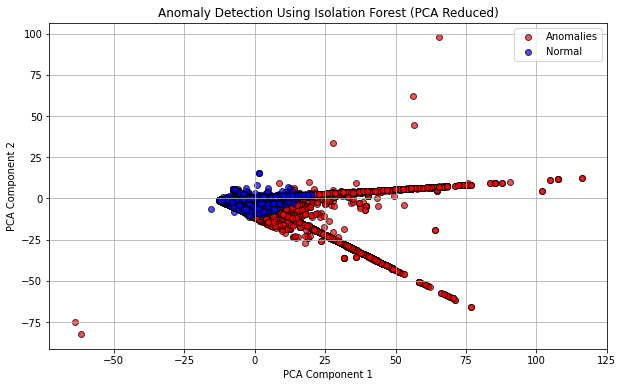

In [81]:
plot_pca(rows_with_missing_features_scaled,cols_to_keep,str(contamination_param))

As we can see, the algorithm worked pretty well for the imputed data as well

## Results

Now it's time to analyze the peformance of our model & iterpret the result

Our features as scaled so we will need to add anomaly labels to our original datafram in order to interpret the features agaist predictions. We will use predictions marked by our Isolation Forest for contamination param 0.25 as it gave is better results.

In [82]:
### Add anomaly results from our model to original df
car_sales_with_anomalies = pd.concat([rows_with_complete_features_scaled, rows_with_missing_features_scaled], axis=0)
car_sales_anom_detec = pd.merge(car_sales_df,car_sales_with_anomalies[['Index','anomaly_0.25']],on=['Index'],how='inner')
car_sales_anom_detec.head()

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,mileage_anomaly,missing_hp,hp_anomaly,missing_disp,cc_anomaly,missing_co2,co2_anomaly,missing_drive,missing_tranm,anomaly_0.25
0,28181,299900,PLN,New,BMW,Seria 5,520d,G30/G31 (2017-),2020,1.000,...,NaN,1,NaN,1,NaN,1,NaN,1,1,1
1,108192,94100,PLN,New,MINI,Clubman,Cooper,None,2021,5.000,...,NaN,1,NaN,1,NaN,1,NaN,0,0,1
2,169791,111900,PLN,New,Smart,Fortwo,& passion,III (2014-),2020,144566.000,...,NaN,1,NaN,1,NaN,1,NaN,0,0,1
3,183941,202000,PLN,New,Volkswagen,Arteon,2.0 TSI Elegance DSG,None,2021,5.000,...,NaN,1,NaN,1,NaN,1,NaN,0,0,1
4,184065,202900,PLN,New,Volkswagen,Arteon,2.0 TSI Elegance DSG,None,2021,5.000,...,NaN,1,NaN,1,NaN,1,NaN,0,0,1


We will also remove any unnecessary columns & separate dataframe into two parts:

- Noraml observations: Observations marked normal by Isolation Forest
- Anomalies: Observations marked outliers by Isolation Forest

In [84]:
miss_cols = ['missing_doors_number','missing_drive', 'missing_tranm','missing_co2','missing_hp','missing_registration_date', 'missing_mileage','missing_disp']
red_cols = ['Vehicle_version', 'Vehicle_generation','Colour', 'Origin_country','Offer_publication_date','Offer_location','Features','door_num_anomaly', 'registration_date_anomaly',
            'Uniform_Price', 'price_anomaly','mileage_anomaly','hp_anomaly', 'cc_anomaly','co2_anomaly',]
car_sales_anom_detec['info_miss'] = car_sales_anom_detec[miss_cols].any(axis=1).astype(int)
car_sales_anom_detec.drop(columns=miss_cols+red_cols,inplace=True)

car_sale_anomalies = car_sales_anom_detec[car_sales_anom_detec['anomaly_0.25']==1]
car_sale_normal = car_sales_anom_detec[car_sales_anom_detec['anomaly_0.25']==0]

In order to make interpretation more sensible, we will create our own label for car type:

- If car age is more than 100, we will mark it as Antiq
- If car age is between 20 to 90, it is classic
- If it's manufactured between 1919 to 1930, we will mark it as Vintage
- Othrwise we will mark it as Modern

In [86]:
#### Genrate Car Type Segment
car_sale_anomalies['car_category'] = car_sale_anomalies.apply(lambda row: categorize_car(row['car_age'], row['Production_year']), axis=1)
car_sale_normal['car_category'] = car_sale_normal.apply(lambda row: categorize_car(row['car_age'], row['Production_year']), axis=1)

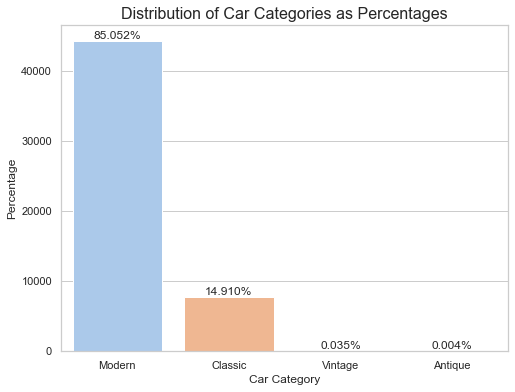

In [89]:
plot_count_plot_car_type(car_sale_anomalies)

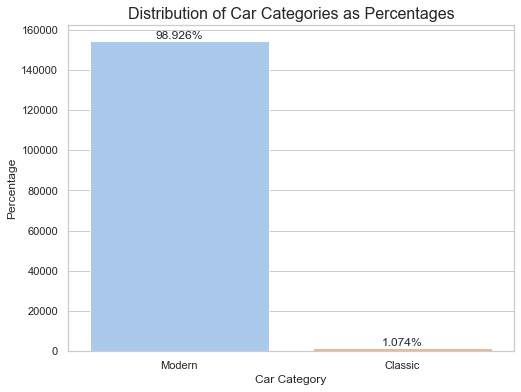

In [90]:
plot_count_plot_car_type(car_sale_normal)


As we can see, all the vintage & Antiq cars are in anomaly dataframe

**Conclusion:** Our model managed to spot age anomalies 

Now let's move to Production & Regisration Gap

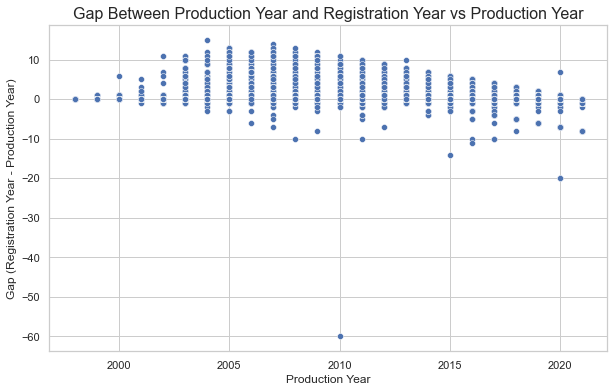

In [93]:
plot_pro_reg(car_sale_normal)


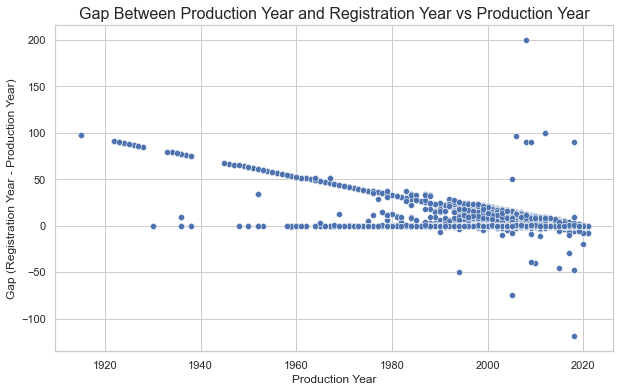

In [94]:
plot_pro_reg(car_sale_anomalies)

This is evident from this plots that most of the weird gaps between production year & registration year is in anomalous dataframe

**Conclustion:** Our model spotted anomalies related to gap

Let's do same for the car price vs age as it has some outliers in terms of price-age

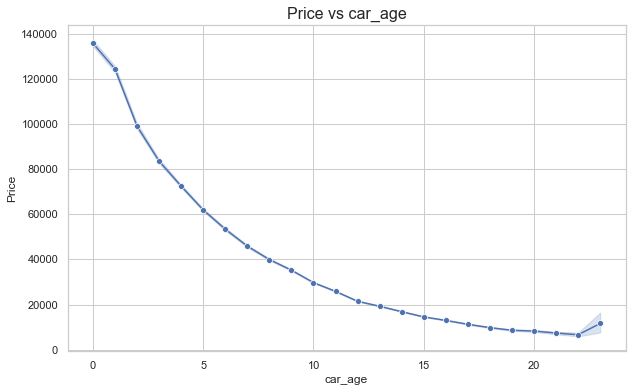

In [95]:
plot_line(car_sale_normal,'car_age','Price')

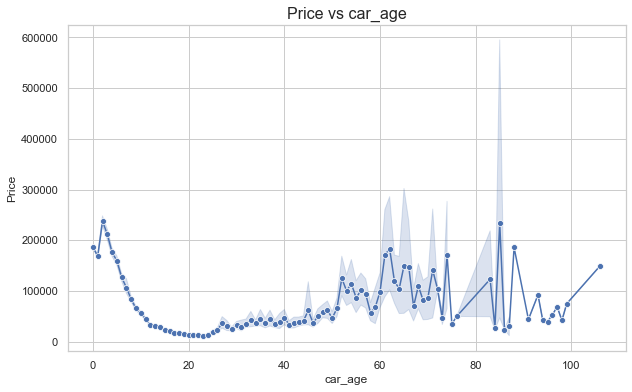

In [96]:
plot_line(car_sale_anomalies,'car_age','Price')

**Conclusion:** 
As opposed to smooth declining graph of price-car age, anomalous dataframe as spikes after age of 40. This confirms our hypothesis that our model spotted antiq, vintage & outlier cars that had weird age-price relationship.

Additionally, we need to look into Miles Covered & Price between used & new cars

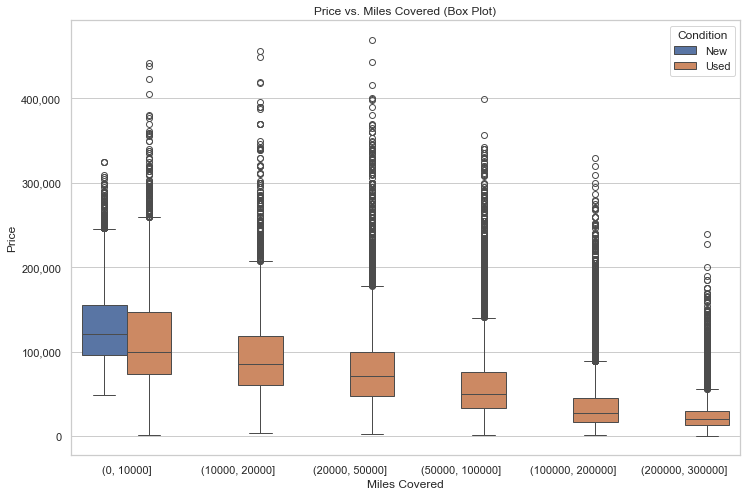

In [98]:
plot_miles_price(car_sale_normal)

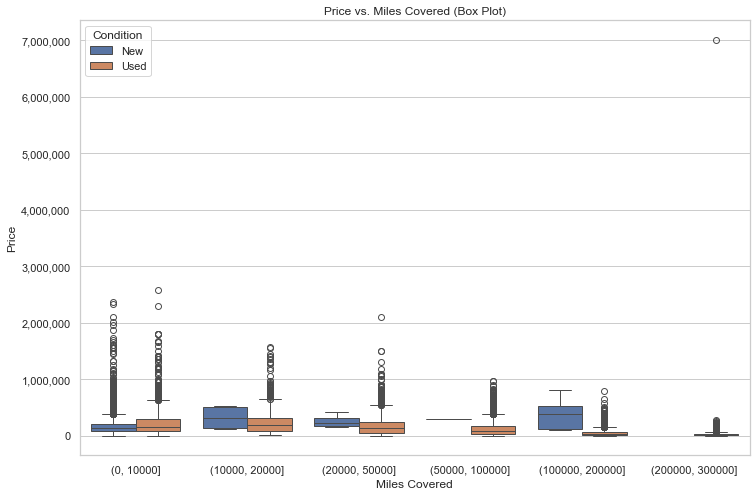

In [99]:
plot_miles_price(car_sale_anomalies)

**Conclusion:** These graphs shows that our model spotted anomalous Ads where supposedly new cars had more than 10K miles covered.

Finally, we will look into Co2 emission for each car type

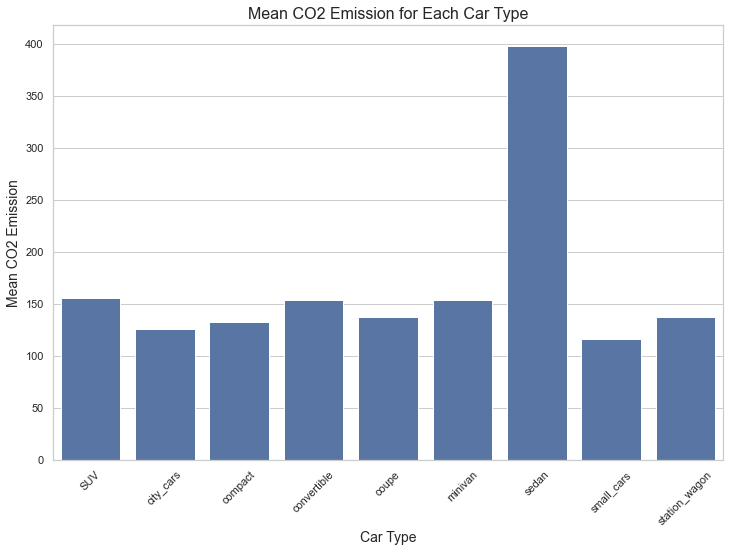

In [101]:
plot_co2_per_type(car_sale_normal)


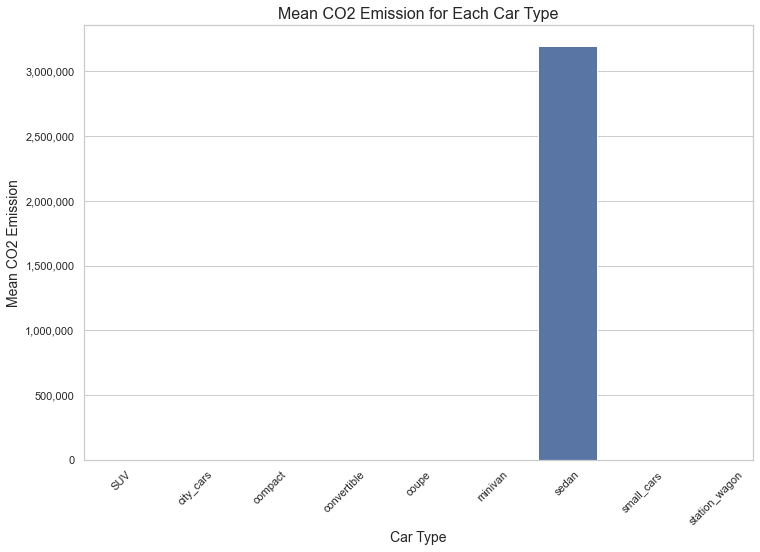

In [106]:
plot_co2_per_type(car_sale_anomalies)

As we can see, our model spotted abnormally high co2 emission Ads as anomalies

### Limitations

In [107]:
car_sale_normal.describe()

,Index,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number,First_registration_date,first_registration_year,prod_reg_gap,car_age,anomaly_0.25,info_miss,Car_Category_Percentage
count,156237.000,156237.000,156237.000,156237.000,156237.000,156237.000,156237.000,156237.000,156237,156237.000,156237.000,156237.000,156237.000,156237.000,156237.000
mean,107084.580,46928.736,2012.228,146179.721,139.261,1776.198,180.650,4.791,2012-11-05 10:12:02.364100352,2012.312,0.085,8.772,0.000,0.786,97.875
min,11.000,500.000,1998.000,1.000,1.000,478.000,1.000,2.000,1950-12-12 00:00:00,1950.000,-60.000,0.000,0.000,0.000,1.074
25%,56557.000,17800.000,2008.000,82700.000,105.000,1496.000,123.000,5.000,2008-10-08 00:00:00,2008.000,0.000,4.000,0.000,1.000,98.926
50%,110812.000,31990.000,2012.000,154000.000,132.000,1781.000,139.000,5.000,2012-11-03 12:00:00,2012.000,0.000,9.000,0.000,1.000,98.926
75%,158700.000,59999.000,2017.000,206000.000,160.000,1995.000,157.000,5.000,2017-02-21 00:00:00,2017.000,0.000,13.000,0.000,1.000,98.926
max,208271.000,469000.000,2021.000,400000.000,510.000,5522.000,1000000.000,55.000,2027-09-28 00:00:00,2027.000,15.000,23.000,0.000,1.000,98.926
std,59842.154,44263.982,5.040,83120.470,49.588,462.754,6196.128,0.546,NaN,5.047,0.679,5.040,0.000,0.410,10.086


In [108]:
car_sale_normal['Doors_number'].value_counts()

Doors_number
5     130745
4      18429
3       6654
2        371
6         27
7          8
55         2
9          1
Name: count, dtype: int64